In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
import sys
sys.path.append("/Users/ccamargo/Documents/github/SLB/")

from utils_SLB import cluster_mean # , sum_linear, sum_square, get_dectime

import scipy.stats as st
# from scipy import stats
import sklearn.metrics as metrics

import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore","Mean of empty slice", RuntimeWarning)
warnings.filterwarnings("ignore","divide by zero encountered in double_scalars", RuntimeWarning)
        

In [4]:

# dimensions
period = ['1993-2017'] # full years
y0,y1=period[0].split('-')
t0='{}-01-01'.format(int(y0))
t1='{}-12-31'.format(int(y1)-1)
path = '/Volumes/LaCie_NIOZ/data/budget/ts/' 
ds = xr.open_dataset(path+'alt.nc')
ds = ds.sel(time=slice(t0,t1))
lat=np.array(ds.lat)
lon=np.array(ds.lon)

In [5]:
#%% get budget components
path = '/Volumes/LaCie_NIOZ/data/budget/'
dic = pd.read_pickle(path+'budget_v2.pkl')

In [6]:
df = pd.DataFrame(
                    {'alt_tr':np.hstack(dic['alt']['trend']),
                     'ssl_tr':np.hstack(dic['steric']['trend']),
                     'bsl_tr':np.hstack(dic['barystatic']['trend']),
                     'dsl_tr':np.hstack(dic['dynamic']['trend']),
                     'sum_tr':np.hstack(dic['sum']['trend'])
                    })

In [7]:
stats = {}

In [8]:

key = '1degree'
#mask:
X = np.array(dic['sum']['trend']) + np.array(dic['alt']['trend'])
mask = np.array(X).flatten()
mask[np.isfinite(mask)] = 1
nn = len(mask[np.isfinite(mask)])

Y = np.array(dic['alt']['ts'])
dimtime,dimlat,dimlon = Y.shape
Y = Y.reshape(dimtime,dimlat*dimlon)

varis = ['sum',
            'steric',
             'barystatic',
             'dynamic',
         'steric+dynamic',
         'barystatic+dynamic',
         'steric+barystatic',
         'steric+barystatic+dynamic'
                   ]
nvar = len(varis)
n = len(mask)
R2 = np.zeros((nn,nvar))
R2.fill(np.nan)
r = np.full_like(R2,np.nan)
rp = np.full_like(R2,np.nan)
RMSE = np.full_like(R2,np.nan)
nRMSE = np.full_like(R2,np.nan)
mRMSE = np.full_like(R2,np.nan)

for j,var in enumerate(varis):
    if len(var.split('+'))==1:
        X = np.array(dic[var]['ts']).reshape(dimtime,dimlat*dimlon)
    else:
        X = np.array([dic[subvar]['ts'] for subvar in var.split('+')])
        X = np.sum(np.array(X),axis=0).reshape(dimtime,dimlat*dimlon)
        
            
    # X = np.array(dic[var]['ts']).reshape(dimtime,dimlat*dimlon)
    ij = 0
    for i, m in enumerate(mask):
        if np.isfinite(m):
            
            y = np.array(Y[:,i])
            y = np.array(y - np.nanmean(y))
            ymean = np.nanmean(y)
            SStot = np.nansum(np.array(y-ymean)**2)
            x = np.array(X[:,i])
            x = np.array(x - np.nanmean(x))
            # plt.plot(x,label=var)
            
            if np.any(np.isnan(x)):
                y = y[np.isfinite(x)]
                x = x[np.isfinite(y)]
            if np.any(np.isnan(y)):
                x = x[np.isfinite(y)]
                y = y[np.isfinite(y)]
                
            SSres = np.sum(np.array(y-x)**2)

            R2[ij,j] = 1 - (SSres/SStot)
            # print('{}:\n R2 = {:.3f}'.format(var, R2[i,j]))

            r[ij,j],rp[ij,j] = st.pearsonr(x,y)
            RMSE[ij,j] = np.sqrt(metrics.mean_squared_error(y,x))
            yrange = np.array(np.nanmax(y) - np.nanmin(y))
            nRMSE[ij,j] = np.array(RMSE[ij,j]/yrange)
            mRMSE[ij,j] = np.array(RMSE[ij,j]/ymean)
            ij = ij+1
            # R = metrics.r2_score(y,x)
            #print('R = {:.3f}'.format(R))
            # print('r = {:.3f} ({:.2e})\n'.format(r[i,j],rp[i,j]))


stats[key] = {'R2':R2,
           'r':r,
           'p_value':rp,
             'RMSE':RMSE,
             'nRMSE':nRMSE,
             'mRMSE':mRMSE}

In [9]:
# key = 'som'
for key in ['som','dmap']:
    
    mask = dic[key]['mask']
    n = dic[key]['n']
    if key =='dmap':
        mask[mask==1]=np.nan
        mask = mask-1
        n = len(np.unique(mask[np.isfinite(mask)]))

    nvar = len(varis)
    R2 = np.zeros((n,nvar))
    r = np.full_like(R2,0)
    rp = np.full_like(R2,0)
    RMSE = np.full_like(R2,np.nan)
    nRMSE = np.full_like(R2,np.nan)
    mRMSE = np.full_like(R2,np.nan)

    for i in range(n):
        icluster = i+1

        maskc = np.array(mask)
        maskc[mask!=icluster] = np.nan
        maskc[np.isfinite(maskc)] = 1

        label = 'alt'
        y =  cluster_mean(np.array(dic[label]['ts']),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)
        # plt.plot(y)

        y = np.array(y- np.nanmean(y))
        ymean = np.nanmean(y)
        yrange = np.array(np.nanmax(y) - np.nanmin(y))
        SStot = np.sum(np.array(y-ymean)**2)
        # plt.plot(y,label='alt')


        for j,var in enumerate(varis):
            if len(var.split('+'))==1:
                X = np.array(dic[var]['ts'])
            else:
                X = np.array([dic[subvar]['ts'] for subvar in var.split('+')])
                X = np.sum(np.array(X),axis=0)

            x = cluster_mean(np.array(X),maskc,lat=np.array(ds.lat),lon=np.array(ds.lon), norm=False)
            x = np.array(x - np.nanmean(x))
            # plt.plot(x,label=var)

            SSres = np.sum(np.array(y-x)**2)

            R2[i,j] = 1 - (SSres/SStot)
            # print('{}:\n R2 = {:.3f}'.format(var, R2[i,j]))

            r[i,j],rp[i,j] = st.pearsonr(x,y)
            RMSE[i,j] = np.sqrt(metrics.mean_squared_error(y,x))
            nRMSE[i,j] = np.array(RMSE[i,j]/yrange)
            mRMSE[i,j] = np.array(RMSE[i,j]/ymean)
            
            # R = metrics.r2_score(y,x)
            #print('R = {:.3f}'.format(R))
            # print('r = {:.3f} ({:.2e})\n'.format(r[i,j],rp[i,j]))

    stats[key] = {'R2':R2,
               'r':r,
               'p_value':rp,
                 'RMSE':RMSE,
             'nRMSE':nRMSE,
             'mRMSE':mRMSE}




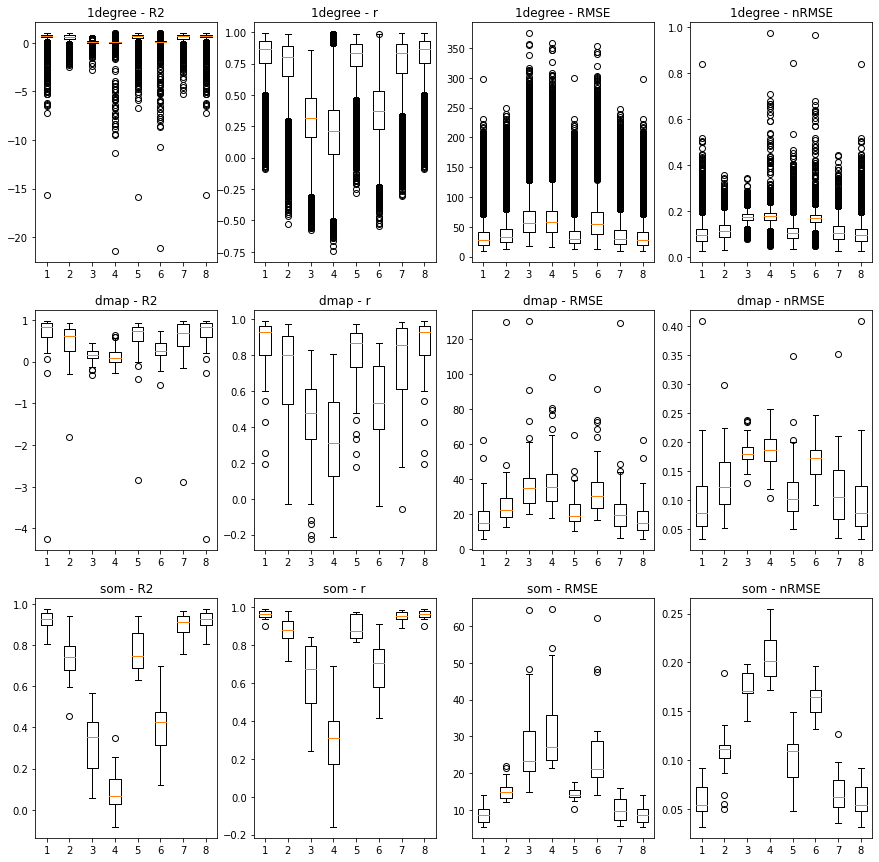

In [10]:
# plot
labels = ['1degree','dmap','som']
fig = plt.figure(figsize=(15,15))
ncol=len(labels)

i=1
varis = ['R2','r','RMSE','nRMSE',
         # 'mRMSE'
        ]
nrow=len(varis)     
for label in labels:
    for var in varis:
        ax1 = plt.subplot(ncol,nrow,i)
        ax1.set_title('{} - {}'.format(label,var))
        ax1.boxplot(stats[label][var])
        # ax1.set_ylim(-2,2)
        i=i+1


In [11]:
# make dataframe
combs = ['(alt,sum)','(alt,ste)','(alt,bar)','(alt,dyn)',
        '(alt,ste+dyn)','(alt,bar+dyn)','(alt,ste+bar)','(alt,ste+dyn+bar)' ]
varis = ['R2','r','RMSE','nRMSE',
         # 'mRMSE'
        ]
labels = ['1degree','dmap','som']
for ilabel, label in enumerate(labels):
    var = varis[0]
    
    data = np.array(stats[label][var])
    i,j = data.shape
    if ilabel==0:
        df = pd.DataFrame({'comb':np.tile(combs,i),
                           'budget':np.tile(label,i*j)
                          })
        for var in varis:
            df[var] = np.array(stats[label][var]).flatten()
    else:
        df2 = pd.DataFrame({'comb':np.tile(combs,i),
                   'budget':np.tile(label,i*j)
                  })
        for var in varis:
            df2[var] = np.array(stats[label][var]).flatten()
        df = df.append(df2)
        


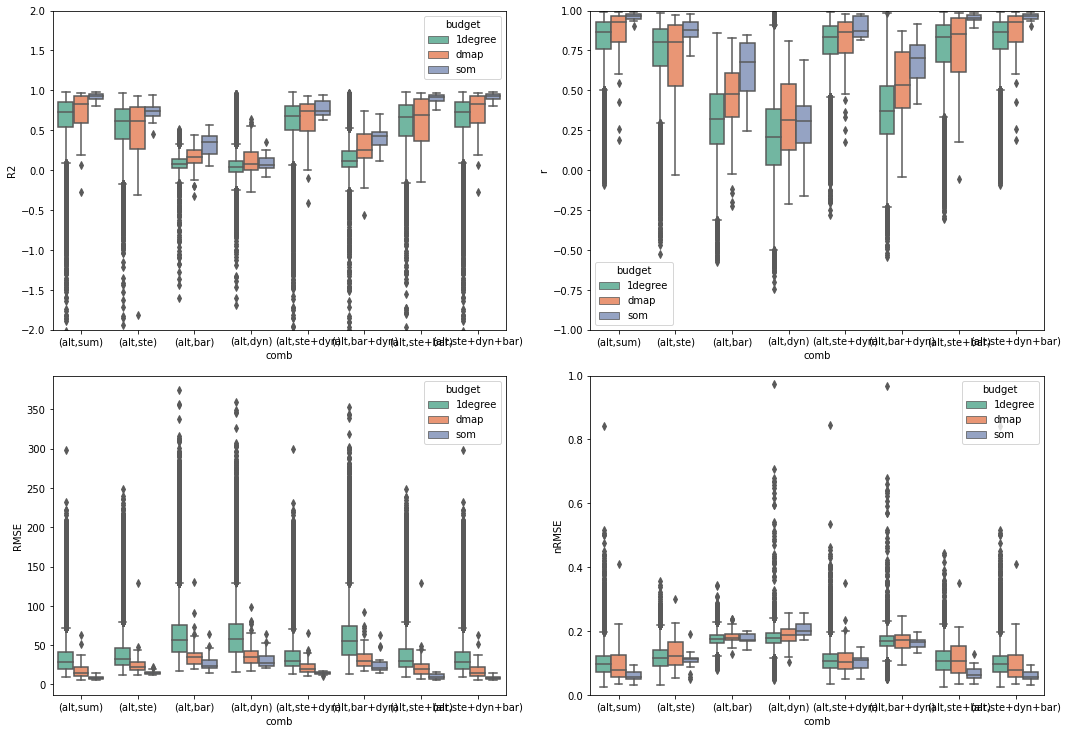

In [12]:
# plot grouped boxplot
ncol=len(varis)
nrow = 2
fig = plt.figure(figsize=(15,5*ncol))
for i,var in enumerate(varis):
    plt.subplot(ncol,nrow,i+1)
    sns.boxplot(x = df['comb'],
                y = df[var],
                hue = df['budget'],
                palette = 'Set2')
    if var=='R2':
        plt.ylim(-2,2)
    if var =='r':
        plt.ylim(-1,1)
    if var=='nRMSE':
        plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Save

In [13]:
df.to_pickle(path+"budget-stats_v2.p")
df

# load pickle module
import pickle
# path = '/Volumes/LaCie_NIOZ/data/budget/'
# create a binary pickle file 
f = open(path+"budget-stats_v2.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(dic,f)

# close file
f.close()

In [14]:
path

'/Volumes/LaCie_NIOZ/data/budget/'